In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from statsforecast import StatsForecast

from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error
import time

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRFRegressor
import lightgbm as lgb


In [2]:
dir='data/store-sales-time-series-forecasting'
file='train.csv'
df=pd.read_csv(f'{dir}/{file}')
df.date=pd.to_datetime(df.date)

store_nbr=list(df.store_nbr.unique())[0]
df_store_nbr=df[df['store_nbr']==store_nbr]
family=list(df_store_nbr.family.unique())[0]
df_store_nbr_family=df_store_nbr[df_store_nbr['family']==family]
df_store_nbr_family=df_store_nbr_family.set_index('date')
#msno.matrix(df_store_nbr_family[['sales']], freq="M")



## Target transformations (Y-side)

We’ll do:
 - log transform (heteroscedasticity)
 - detrend (linear)
 - deseasonalize (weekly)

In [ ]:


# ---------- Target transformations ----------
y = df_store_nbr_family['sales'].copy()

# 1. Log transform (add 1 to handle zeros)
y_log = np.log1p(y)

# 2. Detrend (linear)
t = np.arange(len(y_log)).reshape(-1, 1)
trend_model = LinearRegression()
trend_model.fit(t, y_log.values)
trend = trend_model.predict(t)

y_detrended = y_log - trend

# 3. Deseasonalize (weekly mean)
weekly_seasonality = y_detrended.groupby(y_detrended.index.dayofweek).transform('mean')
y_transformed = y_detrended - weekly_seasonality

y_transformed = y_transformed.dropna()

##  Feature extraction (X-side)
### Time-delay embedding

In [4]:
X = pd.DataFrame(index=y_transformed.index)

# Lags
for lag in [1, 7, 14]:
    X[f'lag_{lag}'] = y_transformed.shift(lag)

# Rolling statistics
X['roll_mean_7'] = y_transformed.rolling(7).mean()
X['roll_std_7'] = y_transformed.rolling(7).std()

# Exponentially weighted mean
X['ewm_7'] = y_transformed.ewm(span=7).mean()

### Temporal embedding

In [5]:
# Calendar features
X['dow'] = X.index.dayofweek
X['month'] = X.index.month

# Time elapsed
X['time_idx'] = np.arange(len(X))

# Fourier terms (weekly)
def fourier_series(t, period, K):
    return pd.DataFrame({
        f'sin_{period}_{k}': np.sin(2 * np.pi * k * t / period)
        for k in range(1, K + 1)
    } | {
        f'cos_{period}_{k}': np.cos(2 * np.pi * k * t / period)
        for k in range(1, K + 1)
    })

fourier = fourier_series(
    t=np.arange(len(X)),
    period=7,
    K=2
)

fourier.index = X.index
X = pd.concat([X, fourier], axis=1)

### Final dataset

In [6]:
data = pd.concat([X, y_transformed.rename('y')], axis=1)
data = data.dropna()

X = data.drop(columns='y')
y = data['y']

## Train / test split (last month as test)

In [7]:
split_date = y.index.max() - pd.offsets.MonthBegin(1)

X_train = X[X.index < split_date]
y_train = y[y.index < split_date]

X_test = X[X.index >= split_date]
y_test = y[y.index >= split_date]

## Models

In [ ]:

models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
    'Decision Tree': DecisionTreeRegressor(max_depth=5),
    'Random Forest': RandomForestRegressor(n_estimators=200, random_state=42),
    'XGB Random Forest': XGBRFRegressor(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8
    ),
    'LightGBM': lgb.LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        num_leaves=31
    )
}


def forecast_bias(y_true, y_pred):
    return 100 * (y_pred.sum() - y_true.sum()) / y_true.sum()



In [9]:
results = []
predictions = {}

for name, model in models.items():
    start = time.time()
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    elapsed = time.time() - start
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    mase = mae / mean_absolute_error(
        y_train[7:], y_train[:-7]
    )
    
    bias = forecast_bias(y_test, y_pred)
    
    results.append({
        'Algorithm': name,
        'MAE': mae,
        'MSE': mse,
        'MASE': mase,
        'Forecast Bias (%)': bias,
        'Time Elapsed': elapsed
    })
    
    # ✅ store predictions
    predictions[name] = y_pred

results_df = pd.DataFrame(results).sort_values('MASE')
results_df

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 1655, number of used features: 13
[LightGBM] [Info] Start training from score -0.001713


,Algorithm,MAE,MSE,MASE,Forecast Bias (%),Time Elapsed
0,Linear Regression,0.136395,0.026914,0.200687,111.679728,0.004485
2,Lasso Regression,0.141474,0.029371,0.208161,121.402032,0.002441
1,Ridge Regression,0.147149,0.031325,0.216511,124.965524,0.001755
6,LightGBM,0.150588,0.032832,0.221570,-23.058254,1.190923
4,Random Forest,0.167140,0.040185,0.245925,123.704104,1.063334
3,Decision Tree,0.244532,0.102714,0.359797,130.756302,0.008837
5,XGB Random Forest,0.385853,0.244809,0.567732,-74.106901,0.328031


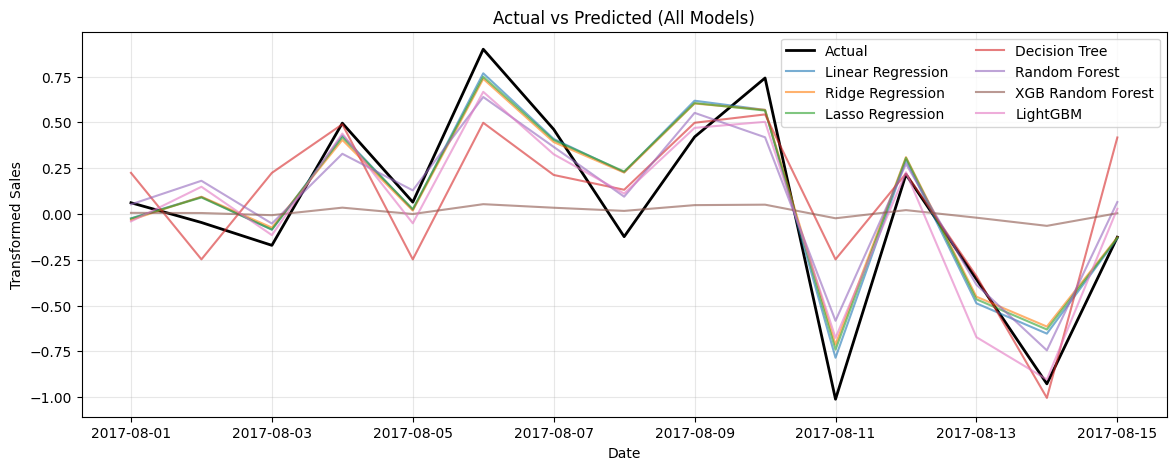

In [10]:
plt.figure(figsize=(14, 5))

plt.plot(y_test.index, y_test.values, 
         label='Actual', 
         color='black', 
         linewidth=2)

for name, y_pred in predictions.items():
    plt.plot(y_test.index, y_pred, 
             label=name, 
             alpha=0.6)

plt.title('Actual vs Predicted (All Models)')
plt.xlabel('Date')
plt.ylabel('Transformed Sales')
plt.legend(ncol=2)
plt.grid(True, alpha=0.3)
plt.show()

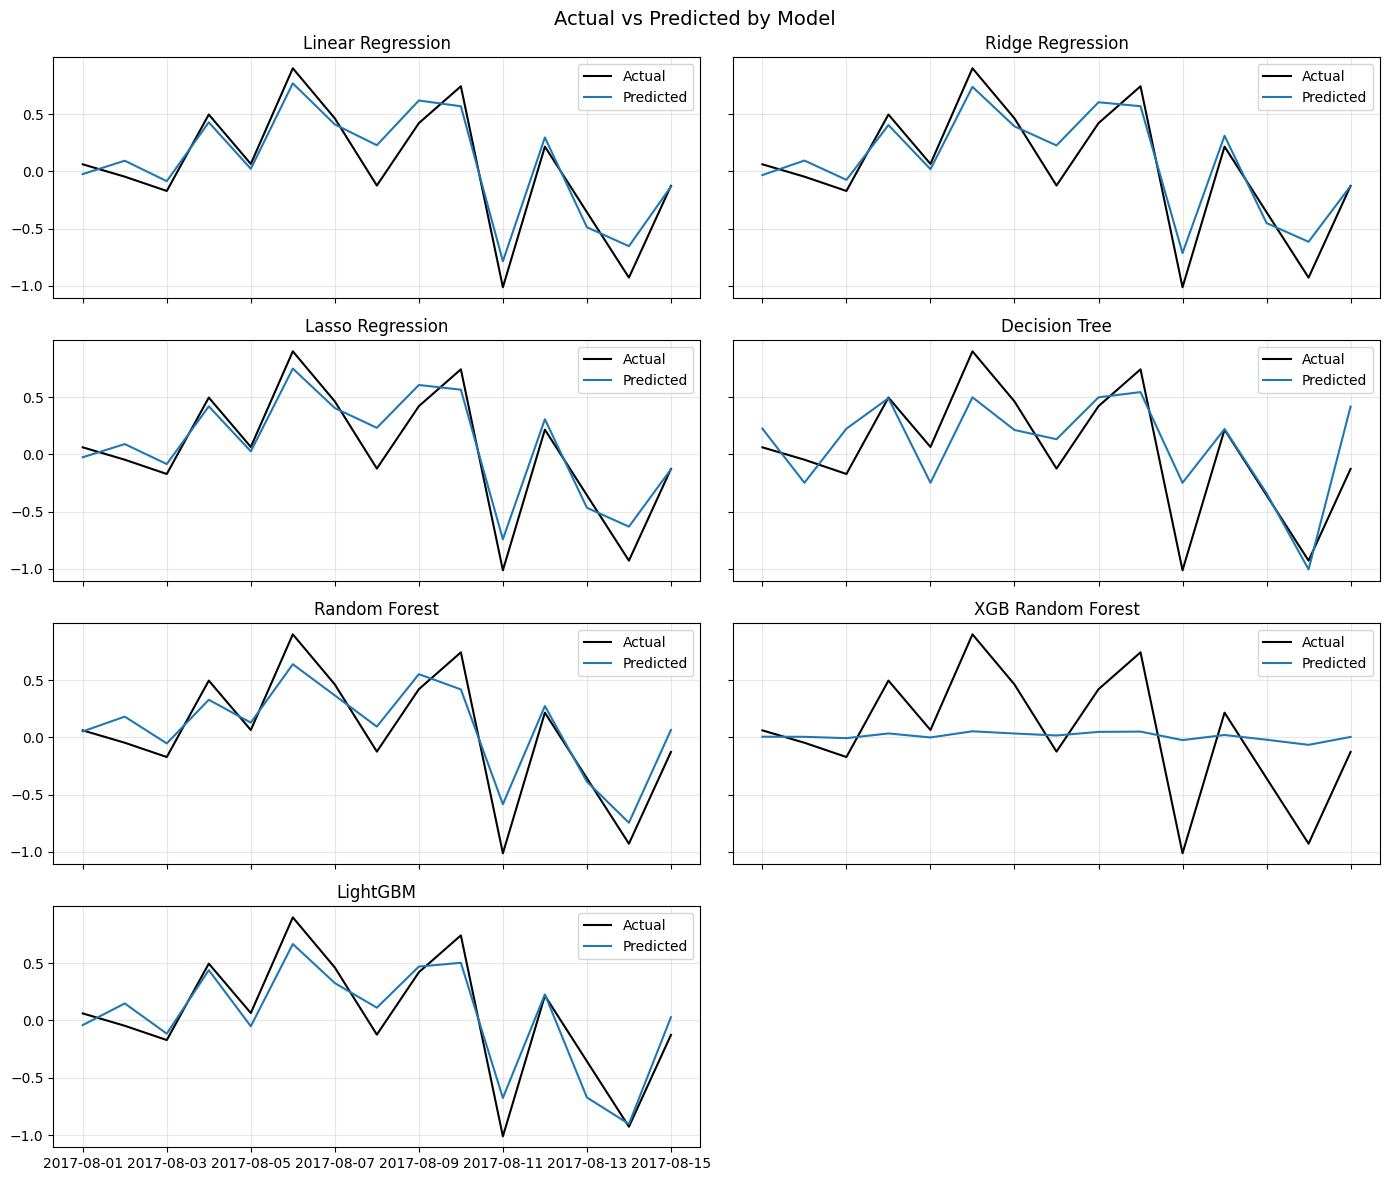

In [11]:
n_models = len(predictions)
n_cols = 2
n_rows = int(np.ceil(n_models / n_cols))

fig, axes = plt.subplots(
    n_rows, n_cols, 
    figsize=(14, 3 * n_rows),
    sharex=True,
    sharey=True
)

axes = axes.flatten()

for ax, (name, y_pred) in zip(axes, predictions.items()):
    ax.plot(y_test.index, y_test.values, 
            label='Actual', 
            color='black')
    
    ax.plot(y_test.index, y_pred, 
            label='Predicted', 
            color='tab:blue')
    
    ax.set_title(name)
    ax.grid(True, alpha=0.3)
    ax.legend()

# Remove empty subplots
for ax in axes[len(predictions):]:
    ax.axis('off')

plt.suptitle('Actual vs Predicted by Model', fontsize=14)
plt.tight_layout()
plt.show()

## For a specific family product - all shops

In [12]:
dir='data/store-sales-time-series-forecasting'
file='train.csv'
df=pd.read_csv(f'{dir}/{file}')
df.date=pd.to_datetime(df.date)
results_list = []
for store_nbr in list(df.store_nbr.unique()):

    df_store_nbr=df[df['store_nbr']==store_nbr]
    family=list(df_store_nbr.family.unique())[0]
    
    
    
    df_store_nbr_family=df_store_nbr[df_store_nbr['family']==family]
    df_store_nbr_family=df_store_nbr_family.set_index('date')
    print(store_nbr,family,df_store_nbr_family.shape)


    # ---------- Target transformations ----------
    y = df_store_nbr_family['sales'].copy()

    # 1. Log transform (add 1 to handle zeros)
    y_log = np.log1p(y)

    # 2. Detrend (linear)
    t = np.arange(len(y_log)).reshape(-1, 1)
    trend_model = LinearRegression()
    trend_model.fit(t, y_log.values)
    trend = trend_model.predict(t)

    y_detrended = y_log - trend

    # 3. Deseasonalize (weekly mean)
    weekly_seasonality = y_detrended.groupby(y_detrended.index.dayofweek).transform('mean')
    y_transformed = y_detrended - weekly_seasonality

    y_transformed = y_transformed.dropna()

    X = pd.DataFrame(index=y_transformed.index)

    # Lags
    for lag in [1, 7, 14]:
        X[f'lag_{lag}'] = y_transformed.shift(lag)

    # Rolling statistics
    X['roll_mean_7'] = y_transformed.rolling(7).mean()
    X['roll_std_7'] = y_transformed.rolling(7).std()

    # Exponentially weighted mean
    X['ewm_7'] = y_transformed.ewm(span=7).mean()

    # Calendar features
    X['dow'] = X.index.dayofweek
    X['month'] = X.index.month

    # Time elapsed
    X['time_idx'] = np.arange(len(X))



    fourier = fourier_series(
        t=np.arange(len(X)),
        period=7,
        K=2
    )

    fourier.index = X.index
    X = pd.concat([X, fourier], axis=1)


    data = pd.concat([X, y_transformed.rename('y')], axis=1)
    data = data.dropna()

    X = data.drop(columns='y')
    y = data['y']


    split_date = y.index.max() - pd.offsets.MonthBegin(1)

    X_train = X[X.index < split_date]
    y_train = y[y.index < split_date]

    X_test = X[X.index >= split_date]
    y_test = y[y.index >= split_date]




    

    for name, model in models.items():
        start = time.time()
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        elapsed = time.time() - start
        
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        
        mase = mae / mean_absolute_error(
            y_train[7:], y_train[:-7]
        )
        
        bias = forecast_bias(y_test, y_pred)
        
        results_list.append({
            'Algorithm': name,
            'MAE': mae,
            'MSE': mse,
            'MASE': mase,
            'Forecast Bias (%)': bias,
            'Time Elapsed': elapsed,
            'family': family,
            'store_nbr': store_nbr
        })
        
        
        
results_df = pd.DataFrame(results_list).sort_values('MASE')
results_df    



1 AUTOMOTIVE (1684, 5)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 1655, number of used features: 13
[LightGBM] [Info] Start training from score -0.001713
10 AUTOMOTIVE (1684, 5)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 1655, number of used features: 13
[LightGBM] [Info] Start training from score 0.006308
11 AUTOMOTIVE (1684, 5)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the tra

/Users/ashhadulislam/miniconda3/envs/py310/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.472e-01, tolerance: 5.240e-02
  model = cd_fast.enet_coordinate_descent(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 1655, number of used features: 13
[LightGBM] [Info] Start training from score -0.018520
53 AUTOMOTIVE (1684, 5)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 1655, number of used features: 13
[LightGBM] [Info] Start training from score 0.003524
54 AUTOMOTIVE (1684, 5)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2825
[LightGBM] [Info] Number of data points in the train set: 1655, number of

,Algorithm,MAE,MSE,MASE,Forecast Bias (%),Time Elapsed,family,store_nbr
44,Lasso Regression,0.083183,0.009801,0.134577,1.418630,0.001028,AUTOMOTIVE,15
43,Ridge Regression,0.083789,0.010360,0.135556,1.340975,0.000989,AUTOMOTIVE,15
42,Linear Regression,0.085071,0.009538,0.137631,2.804907,0.001050,AUTOMOTIVE,15
357,Linear Regression,0.120890,0.021592,0.168974,-163.269155,0.001394,AUTOMOTIVE,7
46,Random Forest,0.105063,0.014751,0.169974,2.921528,1.077982,AUTOMOTIVE,15
...,...,...,...,...,...,...,...,...
333,Random Forest,0.289322,0.148117,6.677701,10.605492,0.924095,AUTOMOTIVE,52
330,Ridge Regression,0.321838,0.173211,7.428181,5.557565,0.000958,AUTOMOTIVE,52
332,Decision Tree,0.354323,0.189744,8.177969,9.065950,0.004235,AUTOMOTIVE,52
331,Lasso Regression,0.358257,0.196053,8.268762,6.599385,0.006946,AUTOMOTIVE,52


In [13]:
results_df

,Algorithm,MAE,MSE,MASE,Forecast Bias (%),Time Elapsed,family,store_nbr
44,Lasso Regression,0.083183,0.009801,0.134577,1.418630,0.001028,AUTOMOTIVE,15
43,Ridge Regression,0.083789,0.010360,0.135556,1.340975,0.000989,AUTOMOTIVE,15
42,Linear Regression,0.085071,0.009538,0.137631,2.804907,0.001050,AUTOMOTIVE,15
357,Linear Regression,0.120890,0.021592,0.168974,-163.269155,0.001394,AUTOMOTIVE,7
46,Random Forest,0.105063,0.014751,0.169974,2.921528,1.077982,AUTOMOTIVE,15
...,...,...,...,...,...,...,...,...
333,Random Forest,0.289322,0.148117,6.677701,10.605492,0.924095,AUTOMOTIVE,52
330,Ridge Regression,0.321838,0.173211,7.428181,5.557565,0.000958,AUTOMOTIVE,52
332,Decision Tree,0.354323,0.189744,8.177969,9.065950,0.004235,AUTOMOTIVE,52
331,Lasso Regression,0.358257,0.196053,8.268762,6.599385,0.006946,AUTOMOTIVE,52


<Figure size 1800x1200 with 0 Axes>

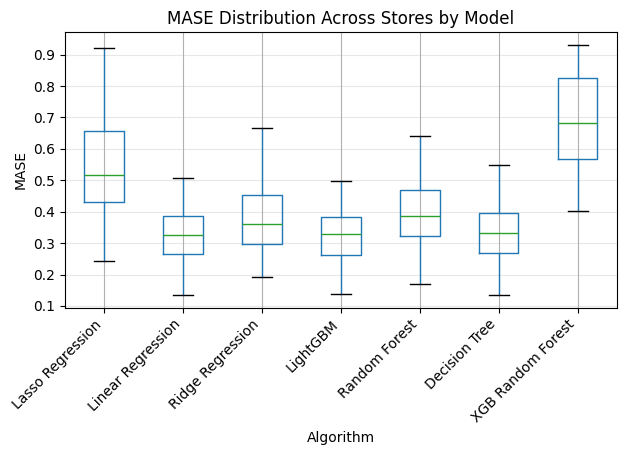

In [17]:
import matplotlib.pyplot as plt

# Ensure correct ordering (best models first)
model_order = (
    results_df
    .groupby('Algorithm')['MASE']
    .median()
    .sort_values()
    .index
)

plt.figure(figsize=(18, 12))

results_df.boxplot(
    column='MASE',
    by='Algorithm',
    #positions=range(len(model_order)),
    showfliers=False
)

plt.xticks(
    ticks=range(1, len(model_order) + 1),
    labels=model_order,
    rotation=45,
    ha='right'
)

plt.title('MASE Distribution Across Stores by Model')
plt.suptitle('')
plt.ylabel('MASE')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()